pybullet build time: Mar  4 2021 20:19:51


robot id None
projection matrix [[ 5.          0.          0.          0.        ]
 [ 0.          5.          0.          0.        ]
 [ 0.          0.         -2.22222222 -1.22222222]
 [ 0.          0.          0.          1.        ]]
[0. 2. 3. 4.]
(138, 7)


/home/ben/ssd/miniconda3/envs/rgbd-sym/lib/python3.9/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


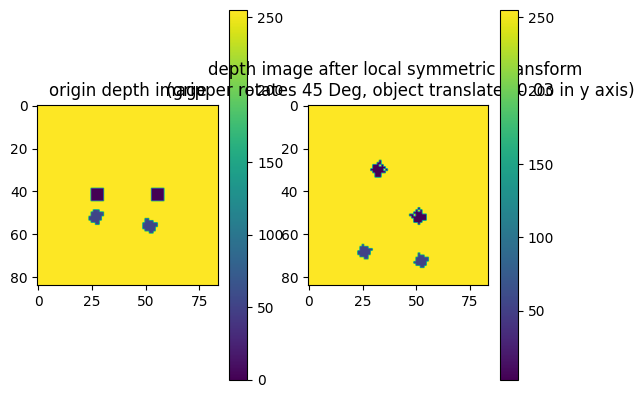

In [1]:
from rgbd_sym.api import make_env
from rgbd_sym.tool.common import getT, TxT, scale_arr
from matplotlib.pyplot import imshow, subplot, axis, cm, show
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from rgbd_sym.tool.depth import get_intrinsic_matrix, depth_image_to_point_cloud, pointclouds2occupancy, occup2image
from rgbd_sym.tool.sym import local_depth_transform
import numpy as np
import cv2
env, env_config = make_env(tags=[], seed=0)
obs = env.reset()
action = env.get_oracle_action()
obs, reward, done, info = env.step(action)


fov = 45
gripper_project_offset = 0.2 # gripper is z zero, so projection is not in FOV45, we need to somehow recover
ws_scale = 0.08
x_offset = +0.00
y_offset = -0.00
z_offset = 0.06
z_scale=12
pc_x_min=-ws_scale+x_offset
pc_x_max=ws_scale+x_offset
pc_y_min=-ws_scale+y_offset
pc_y_max=ws_scale+y_offset
pc_z_min=-ws_scale+z_offset
pc_z_max=ws_scale*z_scale+z_offset
occup_h=80
occup_w=80
occup_d=80

K = get_intrinsic_matrix(obs['depthReal'].shape[0], obs['depthReal'].shape[1], fov=45)
rgb = obs['rgb']
_m = None
for k,v in obs['mask'].items():
    _m = np.logical_or(_m, v) if _m is not None else v
obs['depthReal'][np.logical_not(_m)] = 1
depth = obs['depthReal']
# depth[obs['mask']['gripper']] +=gripper_project_offset # gripper 

depth = scale_arr(obs['depthReal'], 0,1, 0 ,255)
# subplot(1, 2, 1)
# imshow(depth)
# plt.colorbar()
# subplot(1, 2, 2)
# imshow(obs['image'][:,:,0])
# plt.colorbar()
# show()
transform_dict= {}
transform_dict['gripper'] = getT([0,0,0], [0,0,50], rot_type="euler", euler_Degrees=True)
transform_dict['object1'] = getT([0,0.03,0], [0,0,0], rot_type="euler")
transform_dict['object2'] = getT([0,0.03,0], [0,0,0], rot_type="euler")
depth_new =  local_depth_transform(depth,
                        mask_dict=obs['mask'], 
                        transform_dict=transform_dict,
                        K=K, 
                        depth_real_min=0, 
                        depth_real_max=1,
                        gripper_project_offset=gripper_project_offset,
                            pc_x_min=pc_x_min,
                            pc_x_max=pc_x_max,
                            pc_y_min=pc_y_min,
                            pc_y_max=pc_y_max,
                            pc_z_min=pc_z_min,
                            pc_z_max=pc_z_max,
                            occup_h=occup_h,
                            occup_w=occup_w,
                            occup_d=occup_d,
                            background_encoding=255)

ax = subplot(1, 2, 1)
imshow(depth)
plt.colorbar()
ax.set_title("origin depth image")
# subplot(1, 3, 2)
# imshow(obs['image'][:,:,0])
# plt.colorbar()
ax = subplot(1, 2, 2)
imshow(depth_new)
plt.colorbar()
ax.set_title("depth image after local symmetric transform \n (gripper rotates 45 Deg, object translates 0.03 in y axis)")
plt.rcParams['figure.figsize'] = [12, 5]

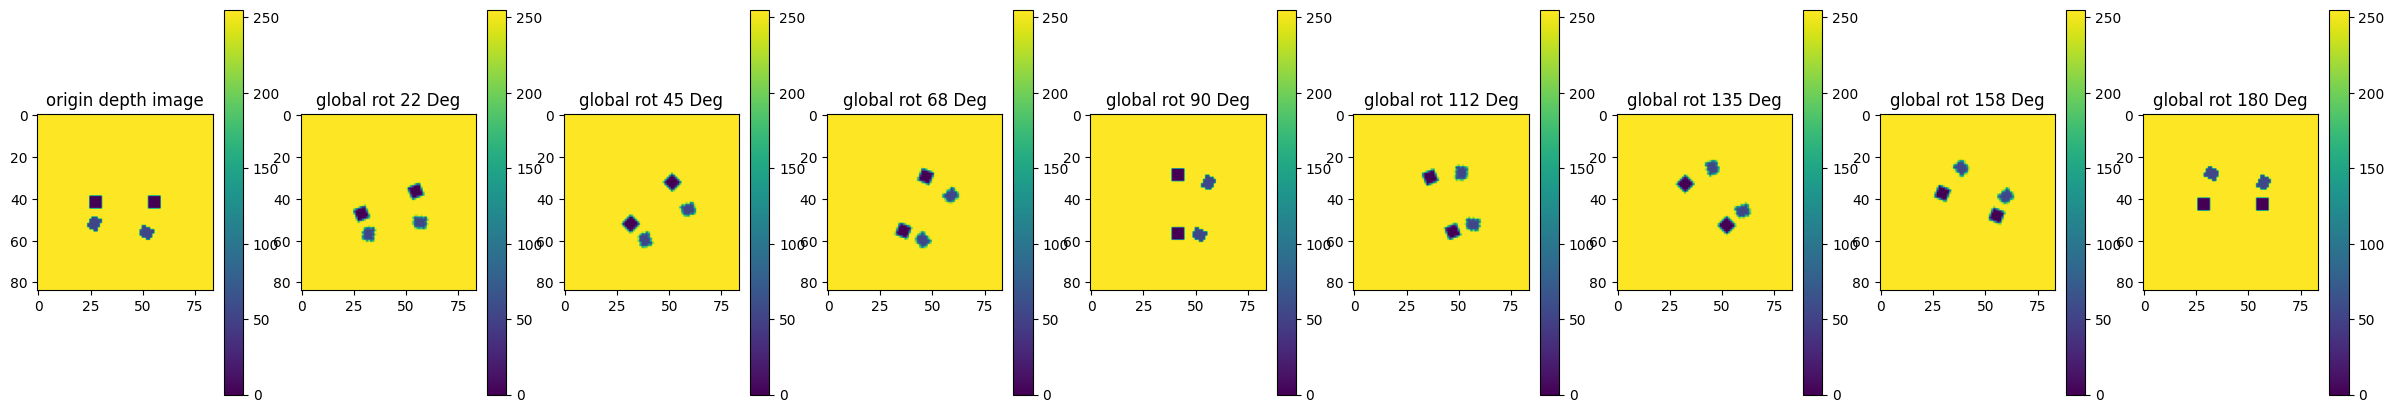

In [6]:
orginal_depth_image = depth.copy()

thetas = np.linspace(0,180, 9).tolist()
ax = subplot(1, len(thetas), 1)
imshow(orginal_depth_image)
plt.colorbar()
plt.rcParams['figure.figsize'] = [30, 5]
ax.set_title("origin depth image")
for i, theta in enumerate(thetas):
    if i == 0:
        continue
    orignal_image = np.stack([orginal_depth_image,]+[np.zeros(orginal_depth_image.shape)]*2, axis=2)
    from rgbd_sym.tool.sym import get_random_transform_params, perturb
    _, trans, pivot = get_random_transform_params(orignal_image.shape)


    new_image, _, action_new, _ = perturb(
            orignal_image,
            None,
            action,
            np.deg2rad(theta),
            trans,
            pivot,
            set_theta_zero=False,
            set_trans_zero=True,
            action_only=False,
        )
    ax = subplot(1, len(thetas), i+1)
    imshow(new_image[:,:,0])
    plt.colorbar()
    ax.set_title(f"global rot {theta:.0f} Deg")


[0. 2. 3. 4.]
(138, 7)
[0. 2. 3. 4.]
(138, 7)
[0. 2. 3. 4.]
(138, 7)
[0. 2. 3. 4.]
(138, 7)
[0. 2. 3. 4.]
(138, 7)
[0. 2. 3. 4.]
(138, 7)
[0. 2. 3. 4.]
(138, 7)
[0. 2. 3. 4.]
(138, 7)


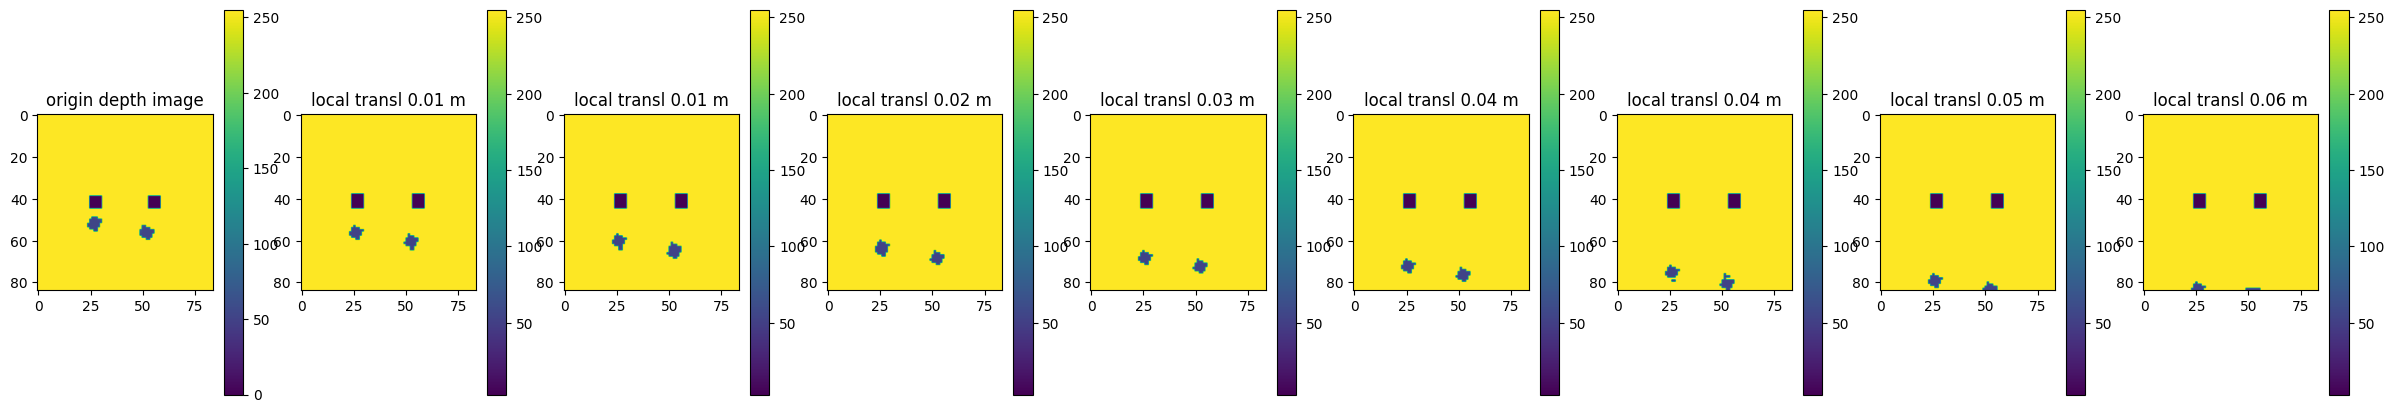

In [3]:
fov = 45
gripper_project_offset = 0.2 # gripper is z zero, so projection is not in FOV45, we need to somehow recover
ws_scale = 0.08
x_offset = +0.00
y_offset = -0.00
z_offset = 0.06
z_scale=12
pc_x_min=-ws_scale+x_offset
pc_x_max=ws_scale+x_offset
pc_y_min=-ws_scale+y_offset
pc_y_max=ws_scale+y_offset
pc_z_min=-ws_scale+z_offset
pc_z_max=ws_scale*z_scale+z_offset
occup_h=80
occup_w=80
occup_d=80

thetas = np.linspace(0,0, 9).tolist()
distances = np.linspace(0,0.06, len(thetas)).tolist()
ax = subplot(1, len(thetas), 1)
plt.rcParams['figure.figsize'] = [30, 5]
imshow(orginal_depth_image)
plt.colorbar()
ax.set_title("origin depth image")

K = get_intrinsic_matrix(orginal_depth_image.shape[0], orginal_depth_image.shape[1], fov=fov)
for i, theta in enumerate(thetas):
    if i == 0:
        continue
    transform_dict= {}
    transform_dict['gripper'] = getT([0,0,0], [0,0,theta], rot_type="euler", euler_Degrees=True)
    transform_dict['object1'] = getT([0,0,0], [0,0,theta], rot_type="euler", euler_Degrees=True)
    transform_dict['object2'] = getT([0,0,0], [0,0,theta], rot_type="euler", euler_Degrees=True)
    transform_dict['object1'] = TxT([transform_dict['object1'],getT([0,distances[i],0], [0,0,0], rot_type="euler", euler_Degrees=True), ])
    transform_dict['object2'] = TxT([transform_dict['object2'],getT([0,distances[i],0], [0,0,0], rot_type="euler", euler_Degrees=True), ])
    depth_new =  local_depth_transform(orginal_depth_image,
                            mask_dict=obs['mask'], 
                            transform_dict=transform_dict,
                            K=K, 
                            depth_real_min=0, 
                            depth_real_max=1,
                            gripper_project_offset=gripper_project_offset,
                                pc_x_min=pc_x_min,
                                pc_x_max=pc_x_max,
                                pc_y_min=pc_y_min,
                                pc_y_max=pc_y_max,
                                pc_z_min=pc_z_min,
                                pc_z_max=pc_z_max,
                                occup_h=occup_h,
                                occup_w=occup_w,
                                occup_d=occup_d,
                                background_encoding=255)

    ax = subplot(1, len(thetas), i+1)
    imshow(depth_new)
    plt.colorbar()
    ax.set_title(f"local transl {distances[i]:.2f} m")


[0. 2. 3. 4.]
(138, 7)
[0. 2. 3. 4.]
(138, 7)
[0. 2. 3. 4.]
(138, 7)
[0. 2. 3. 4.]
(138, 7)
[0. 2. 3. 4.]
(138, 7)
[0. 2. 3. 4.]
(138, 7)
[0. 2. 3. 4.]
(138, 7)
[0. 2. 3. 4.]
(138, 7)


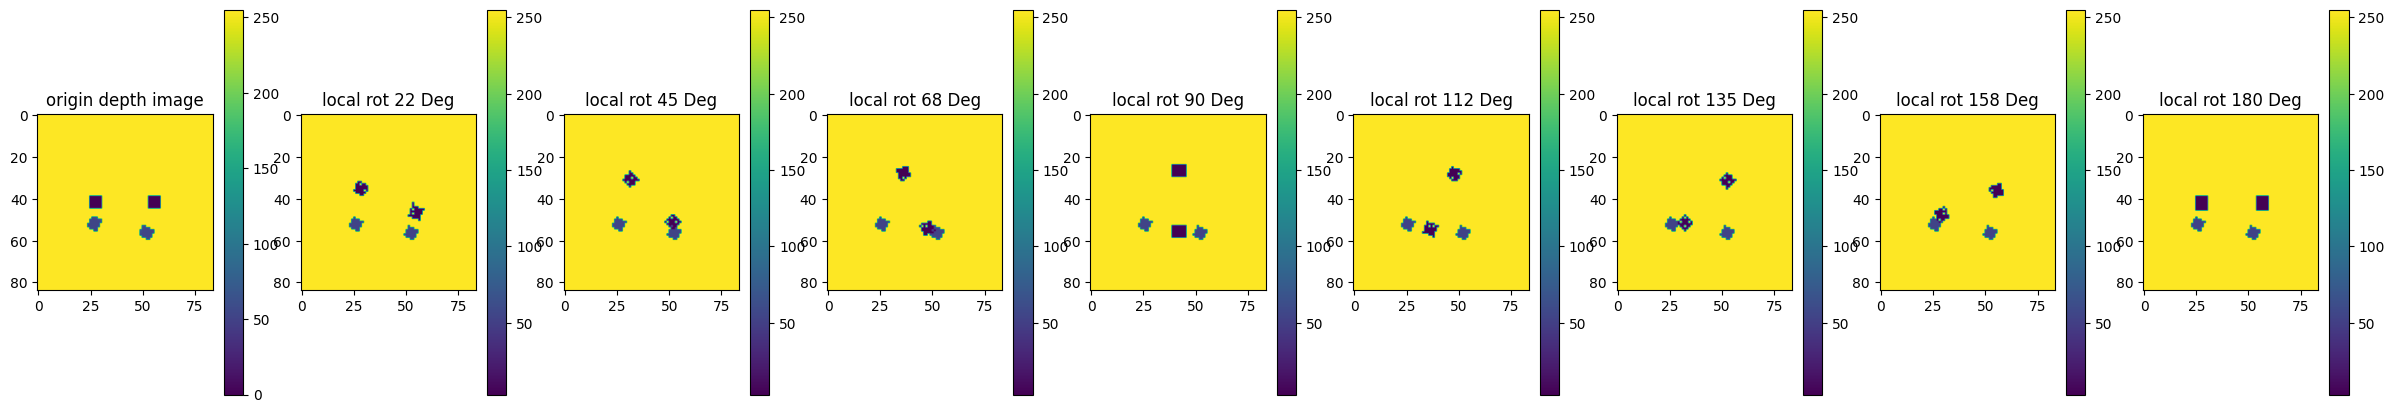

In [4]:
fov = 45
gripper_project_offset = 0.2 # gripper is z zero, so projection is not in FOV45, we need to somehow recover
ws_scale = 0.08
x_offset = +0.00
y_offset = -0.00
z_offset = 0.06
z_scale=12
pc_x_min=-ws_scale+x_offset
pc_x_max=ws_scale+x_offset
pc_y_min=-ws_scale+y_offset
pc_y_max=ws_scale+y_offset
pc_z_min=-ws_scale+z_offset
pc_z_max=ws_scale*z_scale+z_offset
occup_h=80
occup_w=80
occup_d=80

thetas = np.linspace(0,0, 9).tolist()
distances = np.linspace(0,0, len(thetas)).tolist()
local_theta = np.linspace(0, 180, len(thetas)).tolist()
ax = subplot(1, len(thetas), 1)
plt.rcParams['figure.figsize'] = [30, 5]
imshow(orginal_depth_image)
plt.colorbar()
ax.set_title("origin depth image")

K = get_intrinsic_matrix(orginal_depth_image.shape[0], orginal_depth_image.shape[1], fov=fov)
for i, theta in enumerate(thetas):
    if i == 0:
        continue
    transform_dict= {}
    transform_dict['gripper'] = getT([0,0,0], [0,0,theta+local_theta[i]], rot_type="euler", euler_Degrees=True)
    transform_dict['object1'] = getT([0,0,0], [0,0,theta], rot_type="euler", euler_Degrees=True)
    transform_dict['object2'] = getT([0,0,0], [0,0,theta], rot_type="euler", euler_Degrees=True)
    transform_dict['object1'] = TxT([transform_dict['object1'],getT([0,distances[i],0], [0,0,0], rot_type="euler", euler_Degrees=True), ])
    transform_dict['object2'] = TxT([transform_dict['object2'],getT([0,distances[i],0], [0,0,0], rot_type="euler", euler_Degrees=True), ])
    depth_new =  local_depth_transform(orginal_depth_image,
                            mask_dict=obs['mask'], 
                            transform_dict=transform_dict,
                            K=K, 
                            depth_real_min=0, 
                            depth_real_max=1,
                            gripper_project_offset=gripper_project_offset,
                                pc_x_min=pc_x_min,
                                pc_x_max=pc_x_max,
                                pc_y_min=pc_y_min,
                                pc_y_max=pc_y_max,
                                pc_z_min=pc_z_min,
                                pc_z_max=pc_z_max,
                                occup_h=occup_h,
                                occup_w=occup_w,
                                occup_d=occup_d,
                                background_encoding=255)

    ax = subplot(1, len(thetas), i+1)
    imshow(depth_new)
    plt.colorbar()
    ax.set_title(f"local rot {local_theta[i]:.0f} Deg")


[0. 2. 3. 4.]
(138, 7)
[0. 2. 3. 4.]
(138, 7)
[0. 2. 3. 4.]
(138, 7)
[0. 2. 3. 4.]
(138, 7)
[0. 2. 3. 4.]
(138, 7)
[0. 2. 3. 4.]
(138, 7)
[0. 2. 3. 4.]
(138, 7)
[0. 2. 3. 4.]
(138, 7)


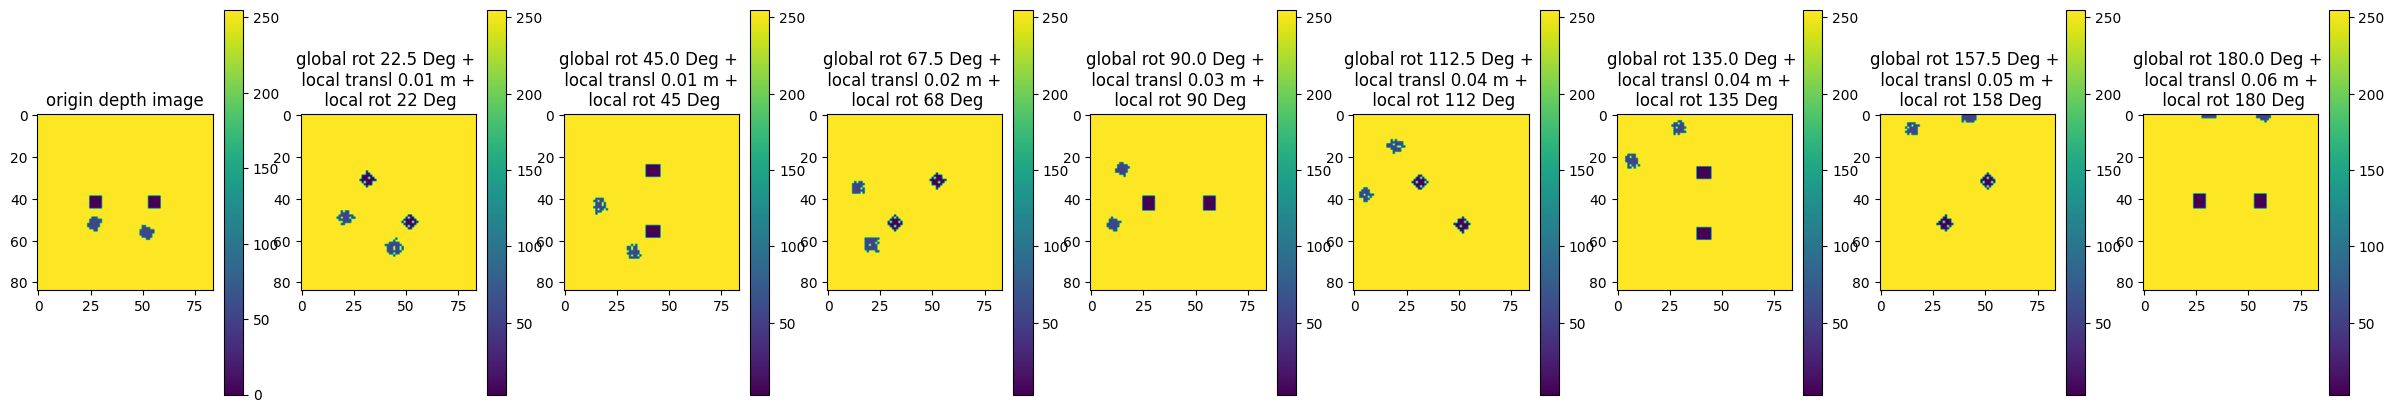

In [5]:
fov = 45
gripper_project_offset = 0.2 # gripper is z zero, so projection is not in FOV45, we need to somehow recover
ws_scale = 0.08
x_offset = +0.00
y_offset = -0.00
z_offset = 0.06
z_scale=12
pc_x_min=-ws_scale+x_offset
pc_x_max=ws_scale+x_offset
pc_y_min=-ws_scale+y_offset
pc_y_max=ws_scale+y_offset
pc_z_min=-ws_scale+z_offset
pc_z_max=ws_scale*z_scale+z_offset
occup_h=80
occup_w=80
occup_d=80

thetas = np.linspace(0,180, 9).tolist()
distances = np.linspace(0,0.06, len(thetas)).tolist()
local_theta = np.linspace(0, 180, len(thetas)).tolist()
ax = subplot(1, len(thetas), 1)
plt.rcParams['figure.figsize'] = [30, 5]
imshow(orginal_depth_image)
plt.colorbar()
ax.set_title("origin depth image")

K = get_intrinsic_matrix(orginal_depth_image.shape[0], orginal_depth_image.shape[1], fov=fov)
for i, theta in enumerate(thetas):
    if i == 0:
        continue
    transform_dict= {}
    transform_dict['gripper'] = getT([0,0,0], [0,0,theta+local_theta[i]], rot_type="euler", euler_Degrees=True)
    transform_dict['object1'] = getT([0,0,0], [0,0,theta], rot_type="euler", euler_Degrees=True)
    transform_dict['object2'] = getT([0,0,0], [0,0,theta], rot_type="euler", euler_Degrees=True)
    transform_dict['object1'] = TxT([transform_dict['object1'],getT([0,distances[i],0], [0,0,0], rot_type="euler", euler_Degrees=True), ])
    transform_dict['object2'] = TxT([transform_dict['object2'],getT([0,distances[i],0], [0,0,0], rot_type="euler", euler_Degrees=True), ])
    depth_new =  local_depth_transform(orginal_depth_image,
                            mask_dict=obs['mask'], 
                            transform_dict=transform_dict,
                            K=K, 
                            depth_real_min=0, 
                            depth_real_max=1,
                            gripper_project_offset=gripper_project_offset,
                                pc_x_min=pc_x_min,
                                pc_x_max=pc_x_max,
                                pc_y_min=pc_y_min,
                                pc_y_max=pc_y_max,
                                pc_z_min=pc_z_min,
                                pc_z_max=pc_z_max,
                                occup_h=occup_h,
                                occup_w=occup_w,
                                occup_d=occup_d,
                                background_encoding=255)

    ax = subplot(1, len(thetas), i+1)
    imshow(depth_new)
    plt.colorbar()
    ax.set_title(f"global rot {theta} Deg + \n local transl {distances[i]:.2f} m + \n local rot {local_theta[i]:.0f} Deg")
